**`MODELO SVM`**

Importaremos las librerías que utilizaremos en este modelo (`SVM`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import label_binarize


Cargamos nuestra base de datos

In [4]:
data = pd.read_csv('../data/Hospitales_Normalizados.csv')
data.head()

,FIEBRE,ITU,SEPSIS,HOSPITALIZACION
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1


Definimos nuestras variables predictoras **'X' _(features)_** y la variable objetivo **'y' _(target)_**

In [5]:
X = data.iloc[:, [0,1,2]].values
Y = data.iloc[:, 3].values

Posteriormente, se separaron los datos de entrenamiento y los datos de prueba, en donde, fueron utilizados el `20%` de nuestros datos totales para evaluar el desempeño de modelo en un entorno simulado. Además, se estandarizaron nuestros valores de entrenamiento.

In [6]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.2, random_state=0)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(X_Train)
X_Test = sc_X.transform(X_Test)

Realizamos una _`búsqueda exhaustiva`_ para encontrar los mejores hiperparámetros del modelo de clasificación. Utilizaremos la técnica de **_Grid Search Cross-Validation_**, que nos permite explorar diferentes combinaciones de hiperparámetros y evaluar su rendimiento mediante la validación cruzada. 

Nuestro objetivo es encontrar los valores óptimos para los hiperparámetros **`'C','kernel' y 'gamma'`**

In [7]:
classifier = SVC()
rango_hiperparametros = {'C': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf'], 
                         'gamma': [0.1, 1, 10]}

modelo =  GridSearchCV(classifier, param_grid = rango_hiperparametros,cv = 5, verbose = True)

modelo.fit(X, Y)

print("Mejores hiperparámetros: "+ str(modelo.best_params_))
print("Mejor Score: "+str(modelo.best_score_)+'\n')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores hiperparámetros: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Mejor Score: 0.9676640926640928



Realizamos un gráfico para analizar la precisión de nuestro modelo variando el parámetro C y observar si coincide con nuestrp resultado en nuestro Grid Search.

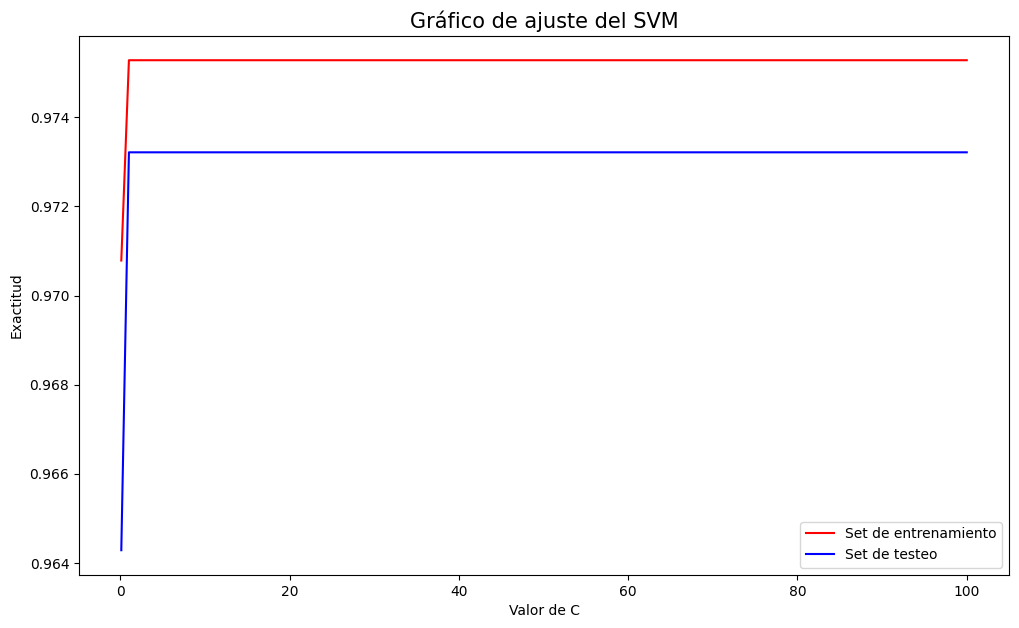

In [8]:
train_prec =  []
test_prec = []
max_KNN_list =  np.logspace(-1, 2, num=4)
for k in max_KNN_list:
    clf_3 = SVC(C=k)
    clf_3.fit(X_Train, Y_Train)
    train_prec.append(clf_3.score(X_Train, Y_Train))
    test_prec.append(clf_3.score(X_Test, Y_Test))

plt.figure(figsize=(12,7))
plt.plot(max_KNN_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_KNN_list, test_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del SVM', fontsize = 15)
plt.legend()
plt.ylabel('Exactitud')
plt.xlabel('Valor de C')
plt.show()

#### Con los resultados de las métricas anteriores,  creamos el modelo de `SVM` con los hiperparametros óptimos, entrenamos el modelo y predecimos la variable objetivo con nuestro set de entrenamiento. 

In [9]:
#Instaciamos el modelo
classifier = SVC (C = 1,gamma=0.1,kernel='linear', probability= True)

#Entrenamos el modelo
classifier.fit(X_Train, Y_Train)

#Predecimos sobre nuestro set de entrenamiento
y_train_pred = classifier.predict(X_Train)
#Predecimos sobre nuestro set de testeo
y_test_pred = classifier.predict(X_Test)

**`Matriz de confusión`**

Fue desarrollado el código para la matriz de confusión de: entrenamiento y testeo, de nuestro modelo

In [10]:
#Para crear la matriz de confusión
from sklearn.metrics import confusion_matrix

matrix_train = confusion_matrix(Y_Train, y_train_pred)
matrix_test = confusion_matrix(Y_Test, y_test_pred)

#Para visualizar
from sklearn.metrics import ConfusionMatrixDisplay

cm_display_train = ConfusionMatrixDisplay(matrix_train)
cm_display_test = ConfusionMatrixDisplay(matrix_test)

#Para obtener el valor de precisión, recall, F1-score y soporte para cada clase en un problema de clasificación
from sklearn.metrics import classification_report

Visualizamos Matriz de confusión de `Entrenamiento`

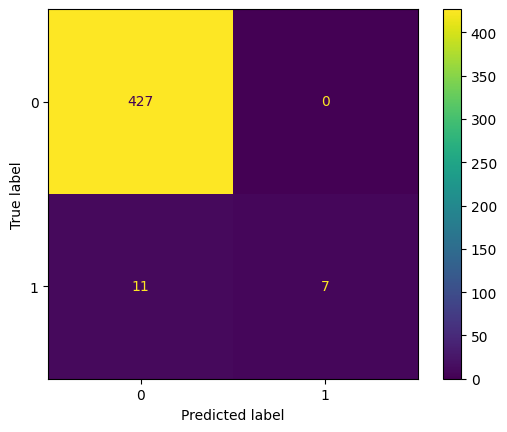

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.97      1.00      0.99       427
           1       1.00      0.39      0.56        18

    accuracy                           0.98       445
   macro avg       0.99      0.69      0.77       445
weighted avg       0.98      0.98      0.97       445



In [11]:
cm_display_train.plot()
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(Y_Train, y_train_pred)}''')

Visualizamos Matriz de confusión de `Testeo`

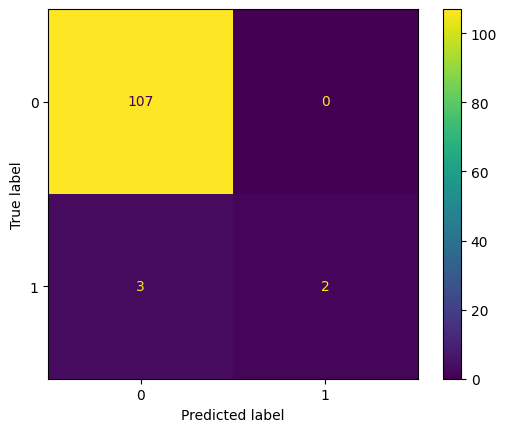

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.97      1.00      0.99       107
           1       1.00      0.40      0.57         5

    accuracy                           0.97       112
   macro avg       0.99      0.70      0.78       112
weighted avg       0.97      0.97      0.97       112



In [12]:
cm_display_test.plot()
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(Y_Test, y_test_pred)}''')

In [13]:
scores_SVM = cross_validate(classifier, X, Y, cv = 10, verbose = True)
print(scores_SVM["test_score"])

[0.94642857 0.96428571 0.98214286 1.         0.98214286 0.96428571
 0.96428571 0.96363636 0.94545455 0.96363636]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


#### **`Curvas ROC `**

Por útimo, evaluamos y comparamos los rendimientos del modelo por medio de Curvas de ROC

In [14]:
from sklearn.preprocessing import label_binarize

# Binarizamos las etiquetas del conjunto de prueba
y_test2 = label_binarize(Y_Test, classes=[0,1,2])

# Obtenemos el número de clases presentes en los datos
n_classes = y_test2.shape[1]

# Calculamos las probabilidades de predicción para cada clase en el conjunto de prueba
y_score = classifier.predict_proba(X_Test)

Calculamos las tasas de falsos positivos (FPR), las tasas de verdaderos positivos (TPR) y el AUC para cada clase en comparación con el resto de las clases.

In [15]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes-1):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



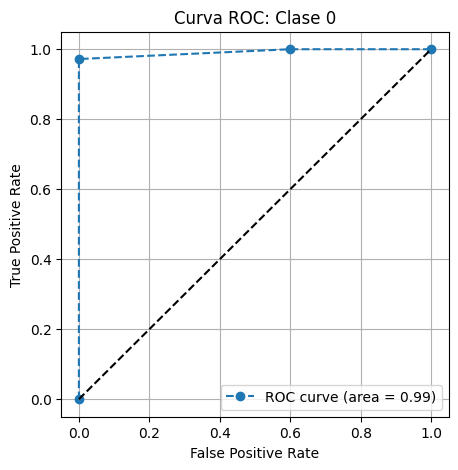

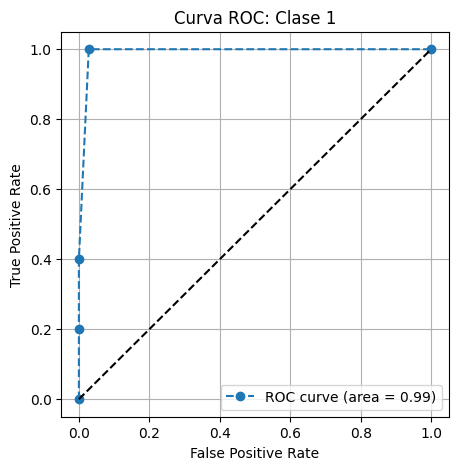

In [16]:
#Recorremos con un bucle cada una de las clases
for i in range(n_classes-1):
    plt.figure(figsize=(5,5))
    plt.plot(fpr[i], tpr[i],'o--', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC: Clase ' + str(i))
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()